In [53]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import time

In [2]:
# gen_initial_perm: Genera una permutacion inicial
# Dada una matriz de adyacencia A, genera la permutacion de vertices sigma, donde
# sigma es la permutacion donde los nodos estan en orden decreciente segun su grado
def gen_initial_perm(A):
    #grados = np.zeros(A.shape[0])
    grados = np.apply_along_axis(sum, 1, A)
    
    return np.flip(np.argsort(grados)) #argsort retorna los indices que ordenan la lista, justo lo que queremos 

In [3]:
#Se genera un grafo aleatorio para testear el algoritmo

G = nx.fast_gnp_random_graph(50,0.4)
L = nx.adjacency_matrix(G).todense()
s = gen_initial_perm(L)
dict_t = {}
for i in range(s.size):
    dict_t[s[i]] = str(i)

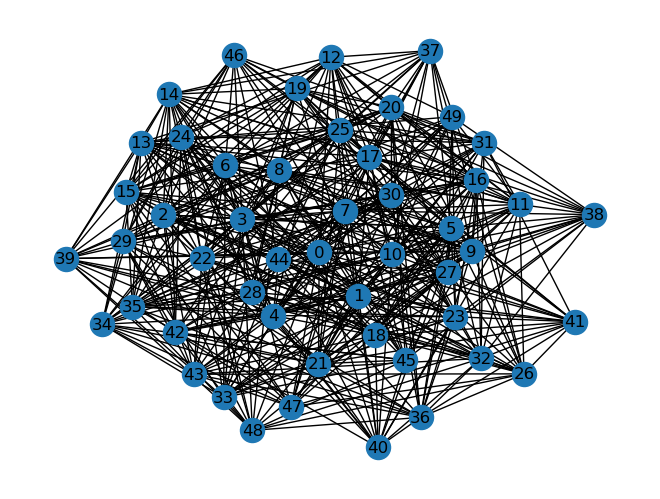

In [4]:
#Se dibujo el grafos
nx.draw(G, labels=dict_t)

In [5]:
# graph_clique : Dibujo el grafo dado y resalta el m-clique dado
# G es el grafo, m es el tamano del clique, sigma es la permutacion de los nodos donde
# sus primeras m entradas son las entradas del clique}
# se advierte que esta funcion solo dibuja, no revisa si efectivamente existe el clique
def graph_clique(G,m,sigma):
    pos = nx.spring_layout(G)
    #print(sigma_lol)
    nodes = {
        'r': sigma[0:m],
        'b': sigma[m:]
    }
    aristas = []
    for i in range(m-1):
        for j in range(i,m):
            aristas.append( (sigma[i],sigma[j]) )

    for node_color, nodelist in nodes.items():
        nx.draw_networkx_nodes(G, pos, nodelist=nodelist, node_color=node_color, node_size = 25)

    labels = {x: x for x in G.nodes}
    #nx.draw_networkx_labels(G, pos, labels, font_size='0', font_color='w')
    nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)
    nx.draw_networkx_edges(G,pos,
                           edgelist=aristas,
                           width=1.5,alpha=0.8,edge_color='r')

# Primera implementación del SA para m-clique

In [6]:
# F : Funcion objetivo a minimizar
# A es matriz de adyacencia, sigma es una permutacion de los nodos, m es el tamano del clique
def F(A, sigma,m):
    h = 0
    for k in range(m-1):
        for l in range(k+1,m):
            h += 1 - A[sigma[k],sigma[l]]
    return h

# F_prima : Funcion auxiliar usada para encontrar vecino
# A es matriz de adyacencia, z es algun indice de algun nodo, m el tamano del clique
def F_prima(z,A,m):
    l = 0
    for i in range(m):
        if i == z: continue
        
        l += A[i,z]
    
    return l
    
# vecino:
# Dada una permutacion, entregua un vecino el cual se obtiene siguiendo las reglas del paper
# m es el numero del clique que se busca, A es matriz de adyacencia
def vecino(sigma,m,A):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Restricting Condition

    while F_prima(u,A,m) > F_prima(w,A,m):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
    new_sig[u] = sigma[w]
    new_sig[w] = sigma[u]
    
    return new_sig

In [7]:
#Decision_SA : Resuelve el problema de decision de m-clique con SA
# m es el tamano del clique, steps es la cantidad maxima de pasos que SA realiza
# A es la matriz de adyacencia del grafo, beta funcion de temperatura
def Decision_SA(m,steps,A,beta):
    sigma = gen_initial_perm(A)
    cost = F(A,sigma,m)
    
    for n in range(steps):
        
        u = np.random.uniform(0, 1)
        sigma_new = vecino(sigma,m,A)
        cost_new =  F(A,sigma_new,m)
        
        if cost_new == 0:
            sigma = sigma_new
            break
        else:
            cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
            if u <= cte:
                sigma = sigma_new
                cost = cost_new
                
    return (sigma_new, n)

## Probando el algoritmo

In [8]:
def beta_lol(n):
    return np.exp(n/10000)

sigma_lol, n_lol = Decision_SA(6,1000000,L,beta_lol)
print(n_lol)

2931


In [9]:
### Beta paper
alpha = 0.9996
def betap(n):
    return (1)/(100*(alpha**n))

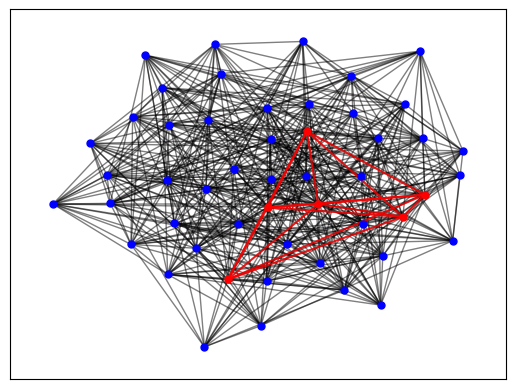

In [10]:
graph_clique(G,6,sigma_lol)

In [11]:
#Clique encontrado por SA
print(sigma_lol[0:6])

[15 18 30 13 36  8]


In [12]:
#Clique aproximado por el algoritmo de aproximacion 
nx.approximation.max_clique(G)

{1, 11, 22, 26, 35}

In [13]:
#Clique encontrado por el algoritmo exacto
for node in G.nodes():
    G.nodes[node]['weight'] = 1

nx.algorithms.max_weight_clique(G)

([16, 42, 4, 8, 29, 5, 36], 7)

## Leyendo grafos de DIMAC 

In [17]:
# read_DIMAC: recibe como input la direccion de un archivo de un grafo dimac en formato ascii
# y entrega un grafo de NetworkX que corresponde al grafo del archivo
def read_DIMAC(archivo):
    edges_d = []

    with open(archivo) as f:
        lines = f.readlines()

    for line in lines:
        if line[0] != 'e':
            continue

        edges_tmp = line[2:].strip().split() 
        for i in range(2):
            edges_tmp[i] =  int(edges_tmp[i]) - 1
        
        edges_d.append(edges_tmp )

    g = nx.Graph()
    g.add_edges_from(edges_d)

    return g

In [18]:
#Leyendo C125.9
C125 = read_DIMAC("dimacs_graphs/C125.9.clq")

for node in C125.nodes():
    C125.nodes[node]['weight'] = 1

In [19]:
sigma_lol, n_lol = Decision_SA(34,100000,nx.adjacency_matrix(C125).todense(),beta_lol)
print(n_lol)

42897


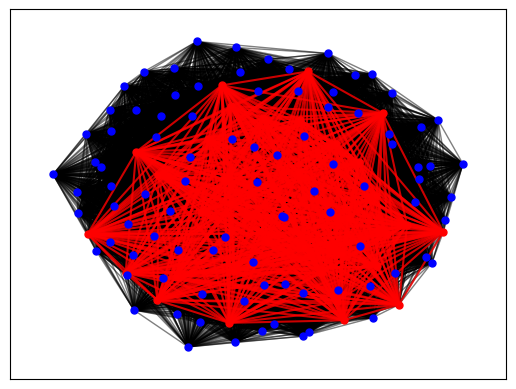

In [20]:
graph_clique(C125,34,sigma_lol)

In [21]:
nx.algorithms.max_weight_clique(C125)

([82,
  67,
  92,
  70,
  121,
  120,
  116,
  78,
  43,
  114,
  30,
  4,
  0,
  47,
  24,
  8,
  1,
  122,
  76,
  33,
  69,
  17,
  48,
  84,
  28,
  10,
  109,
  100,
  81,
  79,
  6,
  113,
  59,
  53],
 34)

In [22]:
#Leyendo gen400_p0.9_65.clq
gen400 = read_DIMAC("dimacs_graphs/gen400_p0.9_65.clq")

for node in gen400.nodes():
    gen400.nodes[node]['weight'] = 1

In [49]:
sigma_lol, n_lol = Decision_SA(45,100000,nx.adjacency_matrix(gen400).todense(),beta_lol)
print(n_lol)

70713


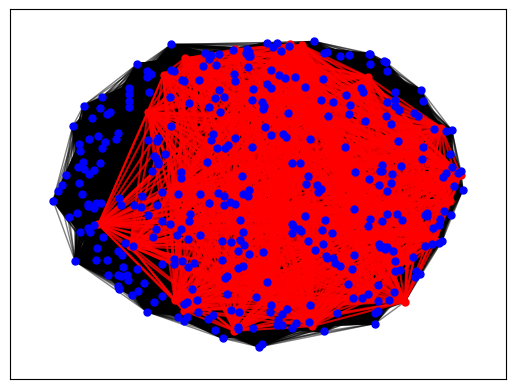

In [50]:
graph_clique(gen400,45,sigma_lol)

In [25]:
#Leyendo brock400_2.clq
brock400_2 = read_DIMAC("dimacs_graphs/brock400_2.clq")

for node in brock400_2.nodes():
    brock400_2.nodes[node]['weight'] = 1

In [28]:
sigma_lol, n_lol = Decision_SA(29,100000,nx.adjacency_matrix(brock400_2).todense(),betap)
print(n_lol)

99999


/tmp/ipykernel_24401/869433061.py:18: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))


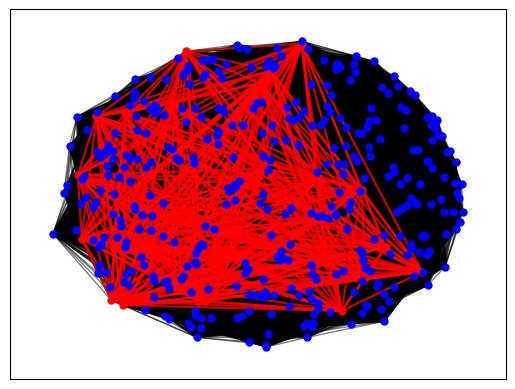

In [30]:
graph_clique(brock400_2,29,sigma_lol)

## Generando estadisticas

In [35]:
# get_estadisticas_decision : 
# Dado un grafo, ejecuta el SA, retornando un vector del numero de pasos que se demoro en terminar
# si es que termino de manera exitosa
def get_estadisticas_decision(A,m,max_step,beta,times):
    contador = 0
    v = np.zeros(times)
    while contador < times:
        sigma, n = Decision_SA(m,max_step,A,beta)
        if n == max_step-1:
            continue
        
        v[contador] = n
        
        contador += 1
    
    return v

In [38]:
# Definiendo temperaturas exponenciales y cuadraticas para comparar
beta_quad = lambda x : (x/10000)**2
beta_exp = lambda x : np.exp(x/10000)

In [39]:
vec_quad = get_estadisticas_decision(L,5,int(1e5),beta_quad,100)
print(vec_quad.mean())
print(vec_quad.std())
vec_exp = get_estadisticas_decision(L,5,int(1e5),beta_exp,100)
print(vec_exp.mean())
print(vec_exp.std())

4166.1
2447.396974338246
404.03
495.1708281997235


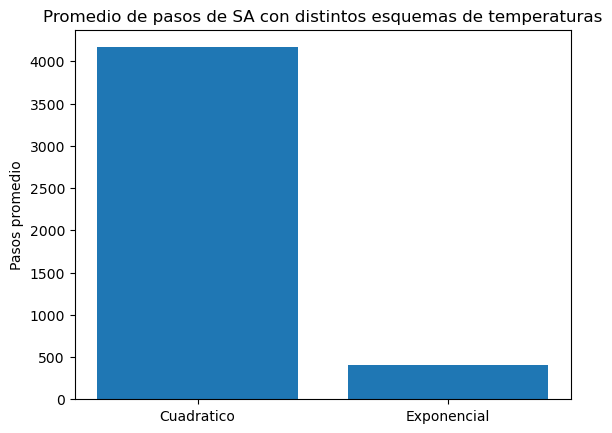

In [46]:
beta_str = ['Cuadratico', 'Exponencial']
plt.bar(beta_str, [vec_quad.mean(),vec_exp.mean()])
plt.title("Promedio de pasos de SA con distintos esquemas de temperaturas")
plt.ylabel("Pasos promedio")
plt.show()

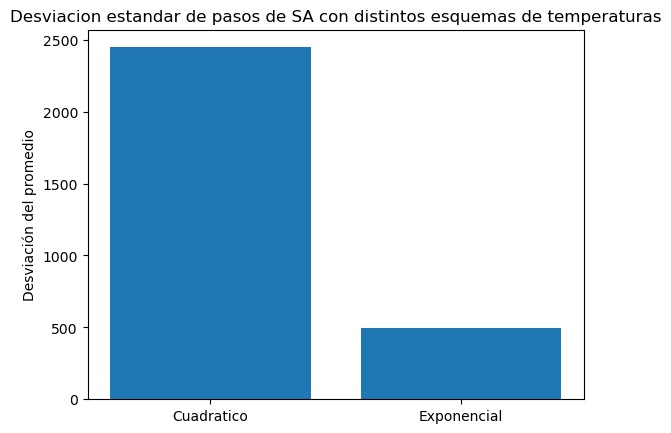

In [48]:
plt.bar(beta_str, [vec_quad.std(),vec_exp.std()])
plt.title("Desviacion estandar de pasos de SA con distintos esquemas de temperaturas")
plt.ylabel("Desviación del promedio")
plt.show()

## Probando en un grafo grande

In [54]:
#Elegimos g400 ya que tiene clique maximo 65

vec_stats = np.zeros(62) #Empieza desde 3
vec_times = np.zeros(62)

max_step = 10000
last_clique_size = 0
end_flag = False

for k in range(62):
    if end_flag: #Aviso de terminar loop
        break
    
    contador = 0
    start = time.time()
    sigma, n = Decision_SA(k+3,max_step,nx.adjacency_matrix(gen400).todense(),beta_lol)
    end = time.time()
    
    vec_stats[k] = n
    vec_times[k] = end-start
    
    while n == max_step-1:
        if contador >= 5:
            end_flag = True
            print("Terminado en ", k+3)
            break
        contador += 1
        
        start = time.time()
        sigma, n = Decision_SA(k+3,max_step,nx.adjacency_matrix(gen400).todense(),beta_lol)
        end = time.time()

        vec_stats[k] = n
        vec_times[k] = end-start

    if vec_stats[k] == max_step-1:
        last_clique_size = k+3

Terminado en  34


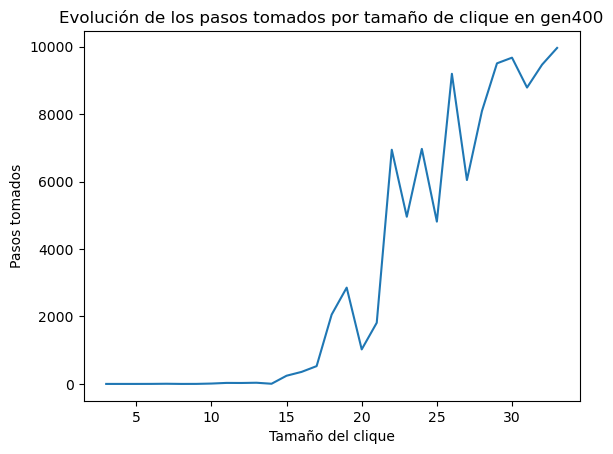

In [75]:
plt.plot( np.arange(3,last_clique_size,1), vec_stats[0:last_clique_size-3])
plt.xlabel("Tamaño del clique")
plt.ylabel("Pasos tomados")
plt.title("Evolución de los pasos tomados por tamaño de clique en gen400")
plt.show()

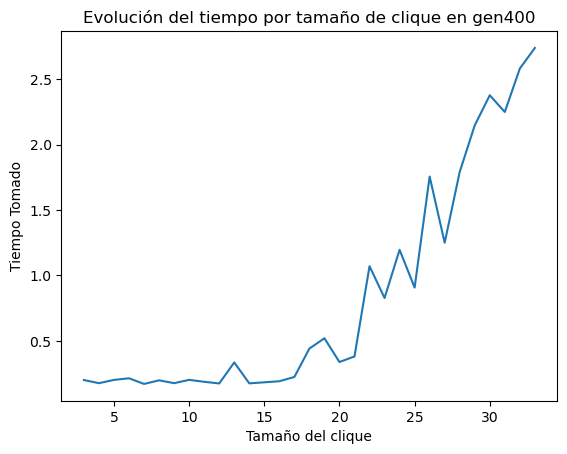

In [74]:
plt.plot( np.arange(3,last_clique_size,1), vec_times[0:last_clique_size-3])
plt.xlabel("Tamaño del clique")
plt.ylabel("Tiempo Tomado")
plt.title("Evolución del tiempo por tamaño de clique en gen400")
plt.show()

## Probando en grafos poco densos y grafos densos

In [121]:
#Obteniendo los grafos con la densidad deseada
nodes_size = 500
densidad = 0

while densidad < 0.8:
    G_denso = nx.fast_gnp_random_graph(nodes_size,0.85)
    L_denso = nx.adjacency_matrix(G_denso).todense()
    densidad = nx.density(G_denso)

densidad = 1
while densidad > 0.2:
    G_ligero = nx.fast_gnp_random_graph(nodes_size,0.15)
    L_ligero = nx.adjacency_matrix(G_ligero).todense()
    densidad = nx.density(G_ligero)
    
    
for node in G_denso.nodes():
    G_denso.nodes[node]['weight'] = 1
    
    
for node in G_ligero.nodes():
    G_ligero.nodes[node]['weight'] = 1

In [122]:

#Obtenenmos sus max cliques con un algoritmo exacto
#denso_clique = nx.algorithms.max_weight_clique(G_denso)[-1]
#ligero_clique = nx.algorithms.max_weight_clique(G_ligero)[-1]

#Mejor con el de aproximacion porque se estaba tardando demasiado
denso_clique = len(list(nx.approximation.max_clique(G_denso)))
ligero_clique = len(list(nx.approximation.max_clique(G_ligero)))

print("denso_clique: ", denso_clique)
print("ligero_clique: ", ligero_clique)

denso_clique:  29
ligero_clique:  5


In [123]:
#Buscando el clique del G denso
max_step = 10000
contador_denso = 0
n_denso = max_step-1
max_iter = 25
while n_denso == max_step-1:
    sigma_denso, n_denso = Decision_SA(denso_clique,max_step,L_denso,beta_lol)
    contador_denso += 1
    if contador_denso >= max_iter:
        print("Se supero limite, forzando break del while")
        break

print("Se tuvo que ejecutar ", contador_denso, " veces el algoritmo para el grafo denso")

Se supero limite, forzando break del while
Se tuvo que ejecutar  25  veces el algoritmo para el grafo denso


In [124]:
#Buscando el clique del G denso
max_step = 10000
contador_ligero = 0
n_ligero = max_step-1
max_iter = 25
while n_ligero == max_step-1:
    sigma_denso, n_ligero = Decision_SA(ligero_clique,max_step,L_ligero,beta_lol)
    contador_ligero += 1
    if contador_ligero >= max_iter:
        print("Se supero limite, forzando break del while")
        break

print("Se tuvo que ejecutar ", contador_ligero, " veces el algoritmo para el grafo ligero")

Se tuvo que ejecutar  15  veces el algoritmo para el grafo ligero


# Primera implementación del SA para MaxClique

La idea es ejecutar el SA anterior, esta vez en un grafo de configuraciones gigante que consiste en la unión de todos los grafos de configuraciones considerados anteriormente, donde cada configuración sera una tupla de la forma $(\sigma,k)$, donde $\sigma$ es la permutación en juego y $k$ es el clique que se esta investigando en el momento del algoritmo, los vecinos de $(\sigma,k)$ son las tuplas de la forma $(\sigma,k+1),(\sigma,k-1),(\tau,k)$ donde $\tau$ es una configuración vecina de $\sigma$ en el grafo del SA original, se subentiende que la ultima etiqueta se toma modulo $n$, ie $0 = n$ donde $n$ es el número de nodos.

Este grafo sigue siendo regular ya que cada nodo tiene los vecinos que tenia en el grafo anterior más dos vecinos adicionales, por ende la regularidad se mantiene.

La función a optimizar en este caso es $H$, la cual es la suma de dos funciones $F_k$ y $p$ de acuerdo al siguente esquema

$$H(\sigma,k) = \alpha F _k(\sigma) + p(k)$$

Donde $F_k(\sigma)$ es la función que se minimizaba anteriormente para el problema de decisión de k-clique, y $p$ es una función de penalización que idealmente es inversamente proporcional al $k$, ie, los $k$ más cercano a $1$ (cliques más pequeños) tienen mayor peso., $\alpha \in \mathbb{R}$ es una sensibilidad ajustable.

In [25]:
# vecino_2 : Elige un vecino dado un sigma y un tamano de clique m
# el vecino puede ser una permutacion vecina con el mismo numero de clique
# o la misma permutacion con el numero de clique cambiado
def vecino_2(sigma,m,A):
    n = A.shape[0]
    new_sig = sigma.copy()
    
    s = np.random.binomial(1, 1/(m*(n-m) + 1) )  #Realmente hay que considerar si este p que estamos tomando es 
                                                 # demasiado pequeno, si es asi, se deben considerar otras formas
    u = np.random.randint(0,m)
    w = np.random.randint(m,n)
    contador = 0
    
    #Caso en que se elige un clique mayor y  no se cambia la permutacon considerada
    
    if s == 1: #Se cambia de clique
        w = np.random.binomial(1, 0.5) #Se tira una moneda balanceada para elegir si se baja o sube
        if w == 2:
            if m == n-1:
                return sigma, 1
            else:
                return sigma, m+1
        else:
            if m == 3:
                return sigma, n-1
            else:
                return sigma, m-1
    
    #Caso en que se cambia la permutacion considerada pero no se cambia el clique
    
    while F_prima(u,A,m) > F_prima(w,A,m):
        contador += 1
        if contador >= 8*n: # se acepta de todas formas
            break
            
        w = np.random.randint(m,n)
    
    new_sig[u] = sigma[w]
    new_sig[w] = sigma[u]
    
    return new_sig, m

#MaxClique_SA
def MaxClique_SA(steps,A,m_inicial,beta, penalizacion,sensibilidad):
    #Inicializacion
    m = m_inicial
    sigma = gen_initial_perm(A)
    cost_clique = F(A,sigma,m)
    cost = sensibilidad*cost_clique + penalizacion(m)
    
    #Se comienza a iterar
    for n in range(steps):
        
        u = np.random.uniform(0, 1)
        
        #Se elige vecino
        sigma_new , m = vecino_2(sigma,m,A)
        
        #Se recuerda que si esto es costo 0, entonces tiene un clique de tamano m
        cost_clique =  F(A,sigma_new,m)
        cost_new = sensibilidad*cost_clique + penalizacion(m)
        
        if cost_clique == 0:
            print("Se ha encontrado clique de tamaño ", m)
            print(sigma_new[:m])

        cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))
            
        if u <= cte:
            sigma = sigma_new
            cost = cost_new
                
    return sigma_new, n

In [26]:
#Se elige una funcion de penalizacion
def p_1(k):
    return 1/(k**3)

In [27]:
sigma_lol, n_lol = MaxClique_SA(100000,L,4,beta_lol,p_1,1)
print(n_lol)


Se ha encontrado clique de tamaño  3
[ 7 33  2]
Se ha encontrado clique de tamaño  3
[10 42 22]
Se ha encontrado clique de tamaño  3
[16 25 45]
Se ha encontrado clique de tamaño  3
[32 39 38]
Se ha encontrado clique de tamaño  3
[32  3 38]
Se ha encontrado clique de tamaño  3
[32 26 45]
Se ha encontrado clique de tamaño  3
[16 26 45]
Se ha encontrado clique de tamaño  3
[ 2 26 39]
Se ha encontrado clique de tamaño  3
[30 25 31]
Se ha encontrado clique de tamaño  3
[43 25 31]
Se ha encontrado clique de tamaño  3
[43 41 31]
Se ha encontrado clique de tamaño  3
[43 41 20]
Se ha encontrado clique de tamaño  3
[ 1 31 43]
Se ha encontrado clique de tamaño  3
[ 1 35 43]
Se ha encontrado clique de tamaño  3
[12  5 16]
Se ha encontrado clique de tamaño  3
[12  5 16]
Se ha encontrado clique de tamaño  3
[12  5 46]
Se ha encontrado clique de tamaño  3
[12 24 46]
Se ha encontrado clique de tamaño  3
[26 25 45]
Se ha encontrado clique de tamaño  3
[26  0 45]
Se ha encontrado clique de tamaño  3
[16

C:\Users\sw_ma\AppData\Local\Temp\ipykernel_22456\541393968.py:67: RuntimeWarning: overflow encountered in exp
  cte = min(1.0, np.exp(-beta(n) * (cost_new - cost)))


Se ha encontrado clique de tamaño  3
[30 25  7]
Se ha encontrado clique de tamaño  3
[30 25 31]
Se ha encontrado clique de tamaño  3
[30 14 31]
Se ha encontrado clique de tamaño  3
[38 14 31]
Se ha encontrado clique de tamaño  3
[38 18 31]
Se ha encontrado clique de tamaño  3
[26 18 31]
Se ha encontrado clique de tamaño  3
[43 18 31]
Se ha encontrado clique de tamaño  3
[44 18 31]
Se ha encontrado clique de tamaño  3
[22 18 31]
Se ha encontrado clique de tamaño  3
[22 32 31]
Se ha encontrado clique de tamaño  3
[41 32 31]
Se ha encontrado clique de tamaño  3
[41 32 22]
Se ha encontrado clique de tamaño  3
[41 19 22]
Se ha encontrado clique de tamaño  3
[32 19 22]
Se ha encontrado clique de tamaño  3
[12 19 22]
Se ha encontrado clique de tamaño  3
[ 4 19 22]
Se ha encontrado clique de tamaño  4
[ 4 19 22 42]
Se ha encontrado clique de tamaño  3
[ 4 19 22]
Se ha encontrado clique de tamaño  3
[ 4 42 22]
Se ha encontrado clique de tamaño  3
[ 4 19  0]
Se ha encontrado clique de tamaño  3


In [62]:
# Probemos ahora con el grafo C125.9
ady = nx.adjacency_matrix(C125).todense()
sigma_lol, n_lol = MaxClique_SA(100000, ady, 9, beta_lol, p_1, 1)
print(n_lol)

Se ha encontrado clique de tamaño  9
[  8  53 113 103  44  26  18 121   3]
Se ha encontrado clique de tamaño  9
[  8  50 113 103  44  26  18 121   3]
Se ha encontrado clique de tamaño  9
[  8  50 113  93  16  26  18 121   3]
Se ha encontrado clique de tamaño  9
[  8  50 113  93  29  26  18 121   3]
Se ha encontrado clique de tamaño  9
[ 55  50  84  48  29  46  64 100   9]
Se ha encontrado clique de tamaño  9
[ 55  50  84  48  22  46  64 100   9]
Se ha encontrado clique de tamaño  9
[ 55  50  77  48  22  46  64 100   9]
Se ha encontrado clique de tamaño  9
[ 21  46  65  48  63  67  64 115   9]
Se ha encontrado clique de tamaño  9
[ 21  46  65  48  63  49  64 115   9]
Se ha encontrado clique de tamaño  9
[21 46 65 48 63 49 64 18  9]
Se ha encontrado clique de tamaño  9
[ 21  46  65  48 119  49  64  18   9]
Se ha encontrado clique de tamaño  9
[ 21  46  65  12 119  49  43  18   9]
Se ha encontrado clique de tamaño  9
[ 21  46  65  12 119  49  43   5   9]
Se ha encontrado clique de tamaño 

Se ha encontrado clique de tamaño  7
[ 27  12  20  72 114  38  59]
Se ha encontrado clique de tamaño  7
[ 27  12  20  72 115  38  62]
Se ha encontrado clique de tamaño  7
[27 12 20 72 91 38 62]
Se ha encontrado clique de tamaño  7
[ 27  12  20  72  91  38 102]
Se ha encontrado clique de tamaño  7
[124  12  20  72  91  38 102]
Se ha encontrado clique de tamaño  7
[124  12  20  72  31  38 102]
Se ha encontrado clique de tamaño  7
[124  12 110  72  31  38 102]
Se ha encontrado clique de tamaño  7
[124  12 110  92  31  38 102]
Se ha encontrado clique de tamaño  7
[124  12 110  61  88  38 102]
Se ha encontrado clique de tamaño  7
[124  12 110  14  88  38 102]
Se ha encontrado clique de tamaño  7
[124  12 110  14  88  60 102]
Se ha encontrado clique de tamaño  7
[124  12 110  14  45  60 102]
Se ha encontrado clique de tamaño  7
[ 24  12 110  14  45  60 102]
Se ha encontrado clique de tamaño  7
[ 24  12 110  14 119  94 102]
Se ha encontrado clique de tamaño  7
[ 49  12 110  14 119  94 102]
Se

99999
